In [1]:
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pd.read_csv('../data/water-daily-production.csv').drop(["Unnamed: 4","Unnamed: 5","Unnamed: 6","Unnamed: 7"],axis=1)
data.tail()

Date  Douglas WTP (ML) Northern WTP (ML)  Daily Production (ML)
3771  28/10/2019            143.85             30.65                 174.50
3772  29/10/2019            148.76             32.63                 181.39
3773  30/10/2019            162.26             32.45                 194.71
3774  31/10/2019            127.02             31.61                 158.63
3775         NaN               NaN               NaN                    NaN

In [3]:
for i in range(3):
    print(data.values[i])

['1/07/2009' 116.37 '31.91' 148.28]
['2/07/2009' 112.98 '33.62' 146.6]
['3/07/2009' 124.23 '33.35' 157.58]


In [4]:
data.isna().sum()

Date                     1
Douglas WTP (ML)         2
Northern WTP (ML)        1
Daily Production (ML)    1
dtype: int64

In [5]:
data=data.dropna()
data=data[data["Northern WTP (ML)"]!='Plant shutown for 1 yearly planned maintenance']
data["Northern WTP (ML)"]=pd.to_numeric(data["Northern WTP (ML)"])
data.index=pd.to_datetime(data.Date,format='%d/%m/%Y')
data=data.drop(["Date","Daily Production (ML)"],axis=1)
data = data.sort_index()

In [6]:
print(data.shape)
data.dtypes

(3760, 2)


Douglas WTP (ML)     float64
Northern WTP (ML)    float64
dtype: object

/home/dalmas/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


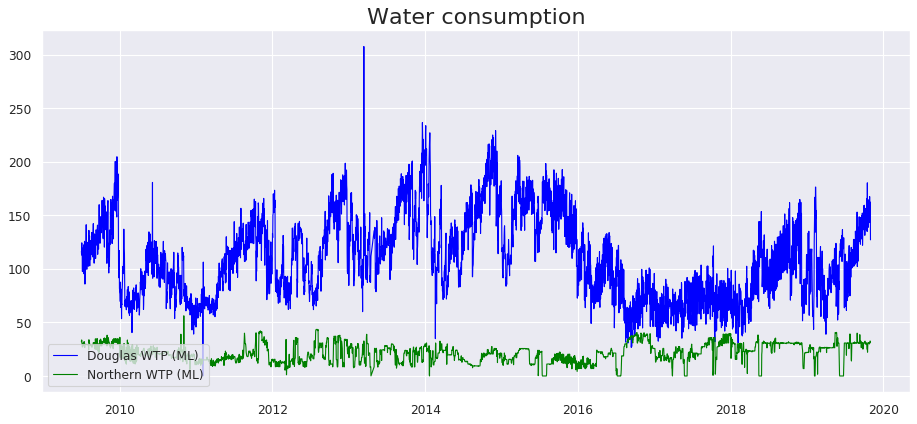

In [7]:
fig,ax = plt.subplots(figsize=(14, 6),dpi=80)
ax.plot(data['Douglas WTP (ML)'], label = 'Douglas WTP (ML)', color='blue',animated=True, linewidth=1)
ax.plot(data['Northern WTP (ML)'], label = 'Northern WTP (ML)', color='green',animated=True, linewidth=1)
#ax.plot(data['Daily Production (ML)'], label = 'Daily Production (ML)', color='red',animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title("Water consumption", fontsize=20)
plt.show()

In [8]:
from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


In [9]:
train = data[: '01-01-2018']
train.to_csv('../data/train.csv')
test = data['01-01-2018':]
test.to_csv('../data/test.csv')
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (3092, 2)
Test dataset shape: (669, 2)


In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)
#X_train = train.values
#X_test = test.values

0         1
0     0.378501  0.568198
1     0.367474  0.598647
2     0.404066  0.593839
3     0.367344  0.536681
4     0.363636  0.491097
5     0.316930  0.479523
6     0.380387  0.504986
7     0.387738  0.530805
8     0.379574  0.544872
9     0.388453  0.498754
10    0.339730  0.500534
11    0.397821  0.531873
12    0.310229  0.559473
13    0.372581  0.571225
14    0.376029  0.571581
15    0.408717  0.514245
16    0.383672  0.471866
17    0.278972  0.522614
18    0.383087  0.524217
19    0.297414  0.523860
20    0.404293  0.524929
21    0.380420  0.525997
22    0.390275  0.523504
23    0.459132  0.522970
24    0.357684  0.522080
25    0.387543  0.522970
26    0.323858  0.520655
27    0.406017  0.521189
28    0.396845  0.519943
29    0.371247  0.517984
...        ...       ...
3062  0.136217  0.670050
3063  0.233599  0.693020
3064  0.154497  0.692664
3065  0.270288  0.548611
3066  0.282127  0.547187
3067  0.220751  0.693376
3068  0.185331  0.691417
3069  0.269019  0.699252
3070  0.150496  0.683405
3071  0.243161  0.546652
3072  0.230151  0.544694
3073  0.165295  0.545940
3074  0.214734  0.690527
3075  0.221564  0.664530
3076  0.326622  0.620014
3077  0.199740  0.695691
3078  0.285803  0.669338
3079  0.259359  0.622863
3080  0.284859  0.548077
3081  0.234770  0.692664
3082  0.199187  0.682514
3083  0.295625  0.703170
3084  0.201886  0.669338
3085  0.203480  0.686254
3086  0.211059  0.695691
3087  0.237567  0.697293
3088  0.227484  0.666489
3089  0.284469  0.674145
3090  0.233859  0.696759
3091  0.200358  0.702279

[3092 rows x 2 columns]

In [22]:
scaler2=joblib.load(scaler_filename)
scaler2.

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
t=4 #number of timesteps
X_train=np.array([X_train[i:i+t] for i in range(X_train.shape[0]-t)])
X_test=np.array([X_test[i:i+t] for i in range(X_test.shape[0]-t)])
print(X_test.shape,X_train.shape)

(665, 4, 2) (3088, 4, 2)


In [12]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [13]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 16)             1216      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 2)              34        
Total para

In [14]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 2933 samples, validate on 155 samples
Epoch 1/100
2933/2933 [==============================] - 14s 5ms/step - loss: 0.1633 - val_loss: 0.1370
Epoch 2/100
2933/2933 [==============================] - 6s 2ms/step - loss: 0.0770 - val_loss: 0.0849
Epoch 3/100
2933/2933 [==============================] - 6s 2ms/step - loss: 0.0485 - val_loss: 0.0429
Epoch 4/100
2933/2933 [==============================] - 7s 2ms/step - loss: 0.0342 - val_loss: 0.0402
Epoch 5/100
2933/2933 [==============================] - 6s 2ms/step - loss: 0.0318 - val_loss: 0.0371
Epoch 6/100
2933/2933 [==============================] - 5s 2ms/step - loss: 0.0310 - val_loss: 0.0387
Epoch 7/100
2933/2933 [==============================] - 5s 2ms/step - loss: 0.0302 - val_loss: 0.0357
Epoch 8/100
2933/2933 [==============================] - 5s 2ms/step - loss: 0.0299 - val_loss: 0.0360
Epoch 9/100
2933/2933 [==============================] - 5s 2ms/step - loss: 0.0296 - val_loss: 0.0368
Epoch 10/100
2933/2933 [=

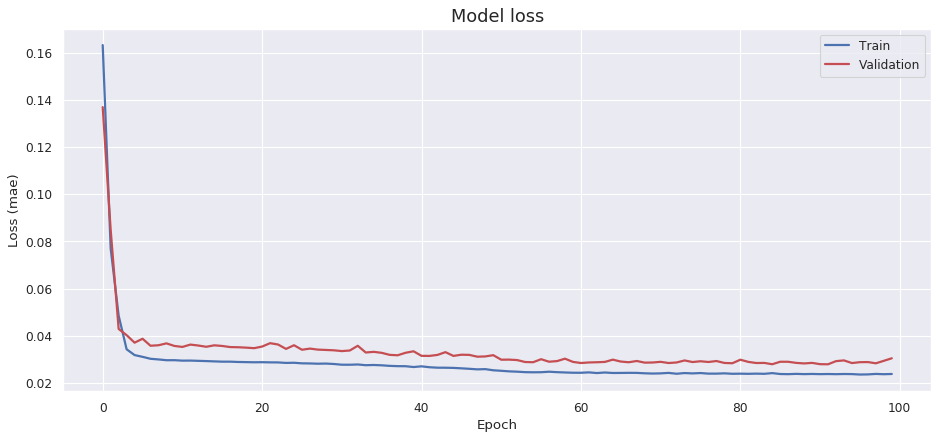

In [15]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

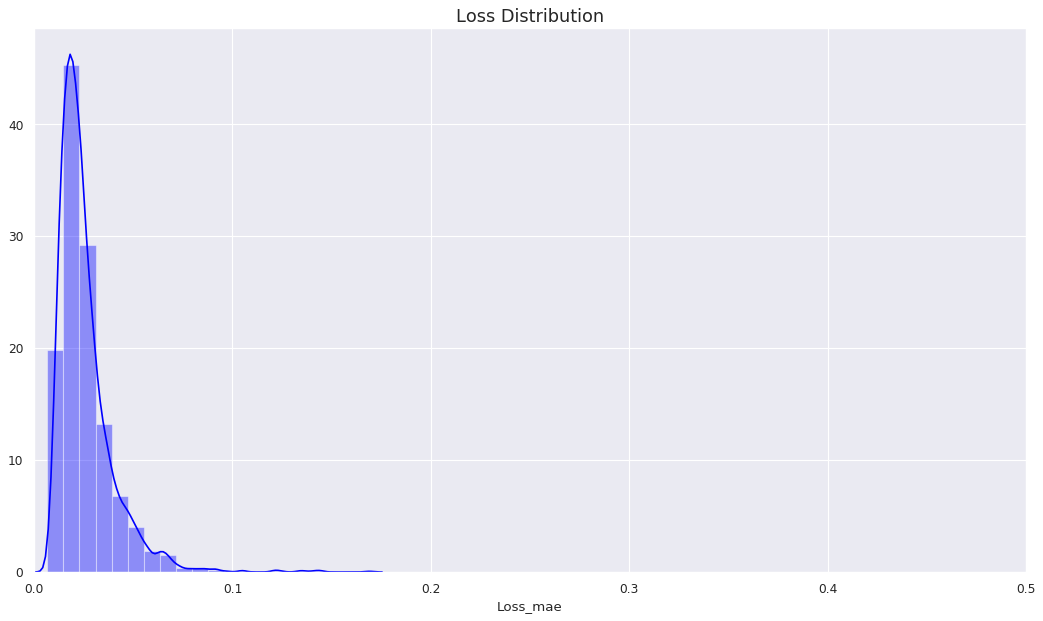

In [16]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
scored = pd.DataFrame(index=train.index[t:])
scored['Loss_mae'] = [np.mean(np.abs(X_pred[i]-X_train[i]))  for i in range(X_train.shape[0])]
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [17]:
#selecting threshold value
# generate gaussian data
from numpy.random import seed
from numpy import mean
from numpy import std
# calculate summary statistics
data_mean, data_std = mean(scored['Loss_mae']), std(scored['Loss_mae'])
# identify outliers
cut_off = data_std * 2 ## 2 standard deviations to capture 95% of data and the 
                       ## the 5% assumed to be anormaly
                       ## the loss distribution is also assumed to follow gauss distribution
print(cut_off)
upper = data_mean + cut_off
upper

0.028190804177247123


0.05385545972182722

In [18]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
scored = pd.DataFrame(index=test.index[t:])
scored['Loss_mae'] = [np.mean(np.abs(X_pred[i]-X_test[i]))  for i in range(X_test.shape[0])]
scored['Threshold']=upper
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored[scored['Loss_mae'] > scored['Threshold']].shape

(27, 3)

In [19]:
# save all model information, including weights, in h5 format
model.save("cloud_model.h5")
print("Model saved")

Model saved
